# Template for Baseline Modeling

It is a very exciting time for NLP.

There are a dizzying amount of different techniques (and different flavors of these techniques available) both in terms of ways to represent words as numbers/vectors, and in terms of the classification models themselves.

This notebook will go over the general steps for fitting and predicting with a classification model, while the subsquent notebooks will explore different varieties of word vectors and classification models, in order to see if certain combinations stick out as the best.

Due to the sheer amount of possible combinations (and the computationally expensive nature of some algorithms and embedding techniques), at present this project is nowhere near a completely exhaustive list of all possible combinations. However, the code in this and the subsequent notebooks can generally be scaled to accomodate many different SKLean models and embedding techniques, as well as the ability to analyze their results visually. In the future I hope to add to the list of models attempted on this dataset, including Neural Networks and more computationally intensive models that could not be included in the interest of time.

Also note that due to the sheer size of this dataset (and the ability to run these notebooks), I have included code to import either the entire dataset, or a specified, stratified subsample of the dataset.

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, average_precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#subset_amount = .15
#raw = pd.read_csv(r'train_preprocessed.csv',
 #           skiprows=lambda i: i>0 and random.random() > subset_amount,
  #       usecols=['clean_question_text','target','qid'])

In [3]:
raw = pd.read_csv('train_preprocessed.csv', usecols=['clean_question_text','target','qid'])

The classifiers won't work with null values, so let's delete any observations that don't have any text post-cleaning.

In [4]:
raw.dropna(inplace=True)

Specify our target (y) and our predictor (X)

In [5]:
X, y = raw.clean_question_text, raw.target

Instantiate the vectorizer

In [6]:
vectorizer = CountVectorizer(min_df=5, max_df=0.7, 
                             stop_words=stopwords.words('english'))  

Even with a GPU, the size of this dataset means that it is extremely prone to memory error during the word vectorization process. So rather than fit/transforming X, and then doing a train/test/split, we will have to fit the vectorizer on X first, and the samples post-Train/Test/Split.

In [7]:
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0) 

In [9]:
X_train = vectorizer.transform(X_train)

In [10]:
X_test = vectorizer.transform(X_test)

Let's instantiate a classifier (Logistic Regression, in this case)

In [11]:
%time
LR_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=42,max_iter=4000,verbose=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


In [12]:
LR_classifier.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)

Generate predictions, as well as predicted probabilities

In [13]:
y_preds_test=LR_classifier.predict(X_test)
y_probas_test=LR_classifier.predict_proba(X_test)

In [14]:
y_preds_train=LR_classifier.predict(X_train)
y_probas_train=LR_classifier.predict_proba(X_train)

In [15]:
y_true_train = y_train.values
y_true_test = y_test.values

Check scores for the Train and Test sets. We will be checking both Accuracy (Correct Predictions over Total Predictions) and F1 Score (a metric that balances False Negatives and False Positives).

In [16]:
accuracy_score(y_true_train, y_preds_train)

0.9569892678985624

In [17]:
f1_score(y_true_train, y_preds_train)

0.5740182414623509

In [18]:
accuracy_score(y_true_test, y_preds_test)

0.9518563617148371

In [19]:
f1_score(y_true_test, y_preds_test)

0.5205354078480723

Looks like these scores are pretty good! They're above the naive baseline of 93.6% (which would be achieved if the classifier selected "sincere" for every observation), and there is very little overfitting when comparing the train and test sets (especially in terms of accuracy score).

Since the classifiers can also give a predicted probability in addition to just a 0 or 1, it can be helpful to look at how the scores could have potentially changed if different probability thresholds were used.

The code below will iterate through different threshold levels, and record/plot the scores at each level. Since our classification task is to flag messages that could be toxic or offensive to users, it would probably make sense to maximize the amount of True Positives, even if it is at the expense of increased False Positives. Different probability levels could also potentially result in different levels of escalation (automatically deleted, flagged for human approval, etc).

Convert the predicted probabilities into a dataframe

In [20]:
pred_proba_df = pd.DataFrame(y_probas_test)

In [21]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                  0.4,0.45,0.5,0.55,0.6,0.65,
                  .7,.75,.8,.85,.9,.95,.99]

In [22]:
true_poses = []
false_poses = []
accuracy_scores = []
prec_scores = []
recall_scores = []

In [23]:
for i in threshold_list:
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    
    new_y_true = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    new_y_preds = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);

    true_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[1][1]
    true_poses.append(true_pos)
    
    false_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[0][1]
    false_poses.append(false_pos)
    
    acc_score = accuracy_score(new_y_true,new_y_preds)
    accuracy_scores.append(acc_score)
    
    precscore = precision_score(new_y_true,new_y_preds)
    prec_scores.append(precscore)
    
    recscore = recall_score(new_y_true,new_y_preds)
    recall_scores.append(recscore)

Create a dataframe to hold the results

In [24]:
prob_results = pd.DataFrame(threshold_list)

In [35]:
prob_results['True_Positives'] = true_poses
prob_results['False_Positives'] = false_poses
prob_results['Accuracy_Scores'] = accuracy_scores
prob_results['Recall_Scores'] = recall_scores
prob_results['Precision_Scores'] = prec_scores
prob_results['F1'] =  2 * ((prob_results['Precision_Scores'] * prob_results['Recall_Scores'])
/   (prob_results['Precision_Scores'] + prob_results['Recall_Scores']))

In [36]:
prob_results.columns = ['thresholds',
                        'True_Positives',
                        'False_Positives',
                        'Accuracy_Scores',
                        'Recall_Scores',
                        'Precision_Scores',
                        'F1']

In [37]:
prob_results.sort_values('True_Positives',ascending=False).head()

,thresholds,True_Positives,False_Positives,Accuracy_Scores,Recall_Scores,Precision_Scores,F1
0,0.05,16036,74,0.256992,0.995407,0.076361,0.141841
1,0.10,15724,386,0.601552,0.976040,0.131697,0.232080
2,0.15,15053,1057,0.804217,0.934389,0.231137,0.370599
3,0.20,14069,2041,0.885092,0.873309,0.334681,0.483911
4,0.25,12964,3146,0.921093,0.804718,0.426097,0.557172


Plot the amount of True Positives and False Positives per threshold level.

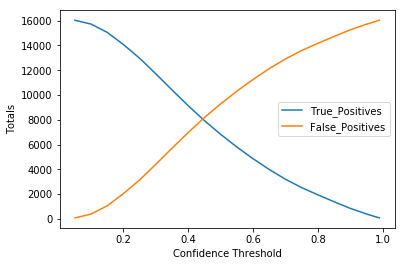

In [40]:
plt.plot('thresholds', 'True_Positives', data=prob_results)
plt.plot('thresholds', 'False_Positives', data=prob_results)
plt.xlabel('Confidence Threshold')
plt.ylabel('Totals')
plt.legend()

Looks like True Positives are maximized at the lowest threshold levels, and go down fairly linearly as the threshold for declaring the positive class increases. This is inline with what's shown on the sorted dataframe above, as well.

Let's look at the different scoring metrics:

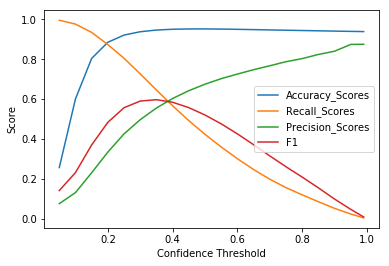

In [39]:
plt.plot('thresholds', 'Accuracy_Scores', data=prob_results)
plt.plot('thresholds', 'Recall_Scores', data=prob_results)
plt.plot('thresholds', 'Precision_Scores', data=prob_results)
plt.plot('thresholds', 'F1', data=prob_results)
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')
plt.legend()

F1 is the harmonic mean of Precision and Recall, so it makes sense that those three metrics all converge at one point. Recall and Precision have essentially the same slope as the True Positives and False Negatives, respectively.

Now let's import a module called eli5 (Explain Like I'm 5), which is often used as a classifier debugged tool, and can help us glean some information about our classifier, as well as specific observations it may have misclassified.

In [43]:
import eli5

In [47]:
eli5.show_weights(LR_classifier, vec = vectorizer, top=(15,15),
                  target_names=["Sincere","Insincere"])

Weight?,Feature
+2.901,castrate
+2.643,castration
+2.167,rejuvalex
+2.149,alabamians
+2.051,scumbags
+1.971,morons
+1.971,moron
+1.906,idiots
+1.883,brainless
+1.880,tennesseans


In [54]:
eli5.explain_prediction(LR_classifier, raw['clean_question_text'][2], vectorizer, target_names=["Sincere","Insincere"])

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n          intercept_scaling=1, max_iter=4000, multi_class='multinomial',\n          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',\n          tol=0.0001, verbose=1, warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Sincere', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.997190547862164, std=None, value=1.0), FeatureWeight(feature='velocity', weight=1.27410807818672, std=None, value=2.0), FeatureWeight(feature='affect', weight=1.0408219494317663, std=None, value=2.0), FeatureWeight(feature='geometry', weight=0.24706985428528014, std=None, value=1.0), FeatureWeight(feature='time', weight=0.07143339389707158, std=None, value=1.0), FeatureWeight(feature='space', weight=0.013663932720557555, std=None, value=1.0)], neg=[], pos_remaining=0, neg_remaining=0), proba=0.9904752174703408, score=-4.64428775638356, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='velocity affect time velocity affect space geometry', spans=[('velocity', [(0, 8)], 1.27410807818672), ('affect', [(9, 15)], 1.0408219494317663), ('time', [(16, 20)], 0.07143339389707158), ('velocity', [(21, 29)], 1.27410807818672), ('affect', [(30, 36)], 1.0408219494317663), ('space', [(37, 42)], 0.013663932720557555), ('geometry', [(43, 51)], 0.24706985428528014)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=2.6470972085213957, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=1.997190547862164, std=None, value=1.0)], neg=[], pos_remaining=0, neg_remaining=0)))], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [55]:
eli5.explain_prediction(LR_classifier, raw['clean_question_text'][9], vectorizer, target_names=["Sincere","Insincere"])

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n          intercept_scaling=1, max_iter=4000, multi_class='multinomial',\n          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',\n          tol=0.0001, verbose=1, warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Sincere', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.997190547862164, std=None, value=1.0), FeatureWeight(feature='phase', weight=0.753404927799173, std=None, value=1.0), FeatureWeight(feature='wherein', weight=0.5543344371565878, std=None, value=1.0), FeatureWeight(feature='feel', weight=0.41140259203445234, std=None, value=2.0), FeatureWeight(feature='things', weight=0.19753946447141846, std=None, value=1.0), FeatureWeight(feature='something', weight=0.18667325938184182, std=None, value=1.0), FeatureWeight(feature='ease', weight=0.1619152429710038, std=None, value=1.0), FeatureWeight(feature='change', weight=0.14508188024225638, std=None, value=1.0), FeatureWeight(feature='completely', weight=0.054299418768330346, std=None, value=1.0), FeatureWeight(feature='way', weight=0.04989927452559537, std=None, value=1.0), FeatureWeight(feature='love', weight=0.049680956161804395, std=None, value=1.0), FeatureWeight(feature='get', weight=0.04691894555242558, std=None, value=1.0), FeatureWeight(feature='ever', weight=0.03508699478228465, std=None, value=1.0), FeatureWeight(feature='live', weight=0.03043426575189752, std=None, value=1.0), FeatureWeight(feature='temporarily', weight=0.01782522036293337, std=None, value=1.0)], neg=[FeatureWeight(feature='ignorant', weight=-1.1664681448799945, std=None, value=1.0), FeatureWeight(feature='disregard', weight=-0.45337373378832757, std=None, value=1.0), FeatureWeight(feature='people', weight=-0.36983741056233865, std=None, value=1.0), FeatureWeight(feature='go', weight=-0.0484880192790837, std=None, value=1.0), FeatureWeight(feature='become', weight=-0.00230355548458475, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9340859331845007, score=-2.65121656382984, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='ever phase wherein become ignorant people love completely disregard feel live get something go way feel temporarily ease things change', spans=[('ever', [(0, 4)], 0.03508699478228465), ('phase', [(5, 10)], 0.753404927799173), ('wherein', [(11, 18)], 0.5543344371565878), ('become', [(19, 25)], -0.00230355548458475), ('ignorant', [(26, 34)], -1.1664681448799945), ('people', [(35, 41)], -0.36983741056233865), ('love', [(42, 46)], 0.049680956161804395), ('completely', [(47, 57)], 0.054299418768330346), ('disregard', [(58, 67)], -0.45337373378832757), ('feel', [(68, 72)], 0.41140259203445234), ('live', [(73, 77)], 0.03043426575189752), ('get', [(78, 81)], 0.04691894555242558), ('something', [(82, 91)], 0.18667325938184182), ('go', [(92, 94)], -0.0484880192790837), ('way', [(95, 98)], 0.04989927452559537), ('feel', [(99, 103)], 0.41140259203445234), ('temporarily', [(104, 115)], 0.01782522036293337), ('ease', [(116, 120)], 0.1619152429710038), ('things', [(121, 127)], 0.19753946447141846), ('change', [(128, 134)], 0.14508188024225638)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.997190547862164, std=None, value=1.0), FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=0.6540260159676756, std=None, value=None)], neg=[], pos_remaining=0, neg_remaining=0)))], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

Let's use this as our baseline template, and try some different types of modeling/word vector combinations.